GAIT ANALYSIS ( Train/Test Split => Oversample only training data outside pipeline => Pipeline (No CV) )

- Aim: Multi-class classification (16 subjects) with oversampling applied before splitting data into train/test sets.

Approach:
- 1: Split original data into train (65%) / test (35%) with stratified sampling
- 2: Oversample only training data using SMOTE/RandomOverSampler (target: 50 samples per class)
- 3: Train pipeline on oversampled training data: StandardScaler -> SelectKBest (k=10) -> SVM/KNeighbors
- 4: Evaluate on original, unmodified test data

Why This Approach?
- Correct way of oversampling: Oversampling happens after the train/test split and only on training data only.
- No data leakage: Test set remains completely untouched by oversampling.
- Realistic evaluation: Test accuracy reflects performance on real, non-synthetic data.

- Data Credits: https://archive.ics.uci.edu/dataset/604/gait+classification

Dataset:
- Original:                   48 samples, 16 classes (3 samples/class)
- Training (original):        32 samples (~2 per class)
- Training (oversampled):     800 samples (50 per class)
- Test (original, unchanged): 17 samples (~1 per class)

Results:
- Training Accuracy (oversampled): 1.0000 (100%)
- Test Accuracy (ORIGINAL):        0.4118 (41%)
- Overfitting Gap:                 0.5882

Upside:
- This is the correct way to use oversampling—never touch the test set.
- 41% accuracy is the real performance of this model.
- Results are not artificially inflated by data leakage.
- 100% training accuracy shows the model can learn from oversampled data (or could be overfitting/memorizing training data).
- Random guessing would achieve ~6.25% (1/16), so 41% is 7× better than random.

Downside:
- Extremely limited test data: Only 1 sample/class (mostly) makes evaluation unstable.
- High variance: Single misclassifications have outsized impact (each test sample = 100% of that class).
- Not person-independent: Train and test contain different samples from the same subjects.
- Low absolute performance: 41% accuracy is insufficient for real-world deployment.
- Even with oversampling to 50 samples/class, model struggles to generalize from only 2 original real samples/class.

What the results tell us:
- SMOTE/RandomOverSampler created enough synthetic samples for the model to learn.
- Training Accuracy = 100%, the model perfectly memorized the oversampled training data.
- Test Accuracy = 41%, the true performance on real, unseen data.
- Overfitting Gap = 59%, the model learned patterns specific to synthetic training data, but do not transfer well to real test samples.

Critical Problems:
- Fundamental data scarcity (train: 2 samples/class | test: 1 samples/class). Even aggressive oversampling cannot compensate for this.
- Test set too small (1 misclassification = 100% error for that class). Results would change with different random splits.
- Model still sees training data from every subject it's tested on (only repetitions of same subjects are available for train and text).
- Not person-independent: Cannot determine if model would work on completely new individuals not previously seen by the model.

Valid for:
- Demonstrating the correct methodology for using oversampling
- Understanding that oversampling cannot create real information from insufficient data
- Establishing a realistic baseline for this dataset

Invalid for:
- Real-world deployment (41% accuracy is too low)
- Person-independent biometric identification
- Claiming the model works well (because it does not works well)
- Making predictions on production data

Key Insight:
- The real performance is 41%, which honestly reflects the fundamental limitation.
- It is next to impossible to reliably train a 16-class classifier with only 2-3 real samples/class, irrespctive of oversampling.

Conclusion:
- The right way to handle oversampling is after split, applied to training only.
- The true cost of data scarcity.
- While the model performs 7× better than random guessing, 41% accuracy is insufficient for practical use.
- The dramatic difference between training (100%) and testing (41%) performance confirms that oversampling, while methodologically sound, cannot compensate for fundamentally insufficient real data.
- This is an honest, unbiased estimate of what this model can actually achieve.


In [67]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [68]:
# Load data
df = pd.read_csv("gait_final_output_updated.csv")
X = df.drop("Subject_ID_Y", axis=1)
y = df["Subject_ID_Y"]


In [69]:
# Check that groups are correct

print("DATA OVERVIEW - y")
print(f"Total samples: {len(y)}")
print(f"Total classes: {len(y.unique())}")
print(f"Samples per class: {y.value_counts().sort_index().tolist()}")

DATA OVERVIEW - y
Total samples: 48
Total classes: 16
Samples per class: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [70]:
# STEP 1: SPLIT FIRST (on original data)
print("STEP 1: SPLIT ORIGINAL DATA FIRST")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, stratify=y, random_state=42
)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(f"Training (original): {len(y_train)} samples")
print(f"Test (original): {len(y_test)} samples")

print("\nTraining distribution:")
print(pd.Series(y_train).value_counts().sort_index().to_list())

print("\nTest distribution:")
print(pd.Series(y_test).value_counts().sort_index().to_list())

STEP 1: SPLIT ORIGINAL DATA FIRST
Training (original): 31 samples
Test (original): 17 samples

Training distribution:
[2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Test distribution:
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [71]:
# STEP 2: OVERSAMPLE ONLY TRAINING DATA
print("STEP 2: OVERSAMPLE ONLY TRAINING DATA")

target_per_class = 50  # Reduced from 100

min_samples = pd.Series(y_train).value_counts().min()
print(f"Minimum samples per class in training: {min_samples}")

if min_samples >= 3:
    print("Using SMOTE...")
    oversampler = SMOTE(random_state=42, k_neighbors=2, \
                       sampling_strategy={cls: target_per_class for cls in np.unique(y_train)})
else:
    
    print("Using RandomOverSampler...")
    oversampler = RandomOverSampler(random_state=42,\
                                   sampling_strategy={cls: target_per_class for cls in np.unique(y_train)})

X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

print(f"\nTraining: {len(y_train)} => {len(y_train_resampled)} (oversampled)")
print(f"Test: {len(y_test)} (ORIGINAL, not oversampled)")


STEP 2: OVERSAMPLE ONLY TRAINING DATA
Minimum samples per class in training: 1
Using RandomOverSampler...

Training: 31 => 800 (oversampled)
Test: 17 (ORIGINAL, not oversampled)


In [79]:
# STEP 3: TRAIN MODEL
print("STEP 3: TRAIN MODEL")
'''
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("feature_selector", SelectKBest(mutual_info_classif, k=10)),
    ("clf", SVC(kernel="rbf", C=1.0, gamma='scale', random_state=42))
])
'''

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("feature_selector", SelectKBest(mutual_info_classif, k=10)),
    ( 'clf'           , KNeighborsClassifier(
            n_neighbors=2,  
            weights='distance', 
            algorithm='auto', 
            leaf_size=30, 
            p=2, 
            metric='manhattan', 
            metric_params=None, 
            n_jobs=-1) )  
])


pipeline.fit(X_train_resampled, y_train_resampled)


STEP 3: TRAIN MODEL


,steps,"[('scaler', ...), ('feature_selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,score_func,<function mut...x75b02d95f6d0>
,k,10
,n_neighbors,2
,weights,'distance'


In [80]:
# STEP 4: EVALUATE ON **ORIGINAL** TEST DATA
print("STEP 4: EVALUATE ON ORIGINAL TEST DATA")

train_accuracy = pipeline.score(X_train_resampled, y_train_resampled)
test_accuracy = pipeline.score(X_test, y_test)  # ORIGINAL test data!

print(f"\nTraining Accuracy (oversampled): {train_accuracy:.4f}")
print(f"Test Accuracy (ORIGINAL): {test_accuracy:.4f}")
print(f"Overfitting Gap: {train_accuracy - test_accuracy:.4f}")

if test_accuracy == 1.0:
    print("\n  100% test accuracy is suspicious!")
    print("   Possible data leakage or test set too easy.")
elif test_accuracy < 0.5:
    print("\n  Low test accuracy on original data")
    print("   This is the REAL performance of the model")
else:
    print(f"\n Real-world test accuracy: {test_accuracy:.2%}")


STEP 4: EVALUATE ON ORIGINAL TEST DATA

Training Accuracy (oversampled): 1.0000
Test Accuracy (ORIGINAL): 0.4118
Overfitting Gap: 0.5882

  Low test accuracy on original data
   This is the REAL performance of the model


In [81]:
# Predictions on ORIGINAL test set
y_pred = pipeline.predict(X_test)

print("CLASSIFICATION REPORT (ORIGINAL TEST SET)")
print(classification_report(y_test, y_pred, zero_division=0))


CLASSIFICATION REPORT (ORIGINAL TEST SET)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.50      1.00      0.67         1
           4       0.50      1.00      0.67         1
           5       0.00      0.00      0.00         1
           6       1.00      1.00      1.00         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       0.33      1.00      0.50         1

    accuracy                          

In [82]:
# Confusion Matrix:
#               Predicted
#               0   1   2
# Actual    0  [10  3   2]  => sum(axis=1) = 15 (total actual class 0)
#           1  [ 2  8   0]  => sum(axis=1) = 10 (total actual class 1)
#           2  [ 1  2  12]  => sum(axis=1) = 15 (total actual class 2)
#               =   =   =
#        axis = 0: 13  13  14 (total predicted per class)

In [83]:
# Confusion Matrix
print("CONFUSION MATRIX (ORIGINAL TEST SET)")

heatmap_labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=heatmap_labels)
print(cm)

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class accuracy on ORIGINAL test data:")
for cls, acc in zip(heatmap_labels, per_class_acc):
    print(f"  Class {cls:2d}: {acc:.2%} ({int(cm[cls, cls])}/{int(cm.sum(axis=1)[cls])} correct)")


CONFUSION MATRIX (ORIGINAL TEST SET)
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]

Per-class accuracy on ORIGINAL test data:
  Class  0: 0.00% (0/1 correct)
  Class  1: 0.00% (0/1 correct)
  Class  2: 0.00% (0/1 correct)
  Class  3: 100.00% (1/1 correct)
  Class  4: 100.00% (1/1 correct)
  Class  5: 0.00% (0/1 correct)
  Class  6: 100.00% (2/2 correct)
  Class  7: 0.00% (0/1 correct)
  Class  8: 0.00% (0/1 correct)
  Class  9: 0.00% (0/1 correct)
  Class 10: 0.00% (0/1 correct)
 

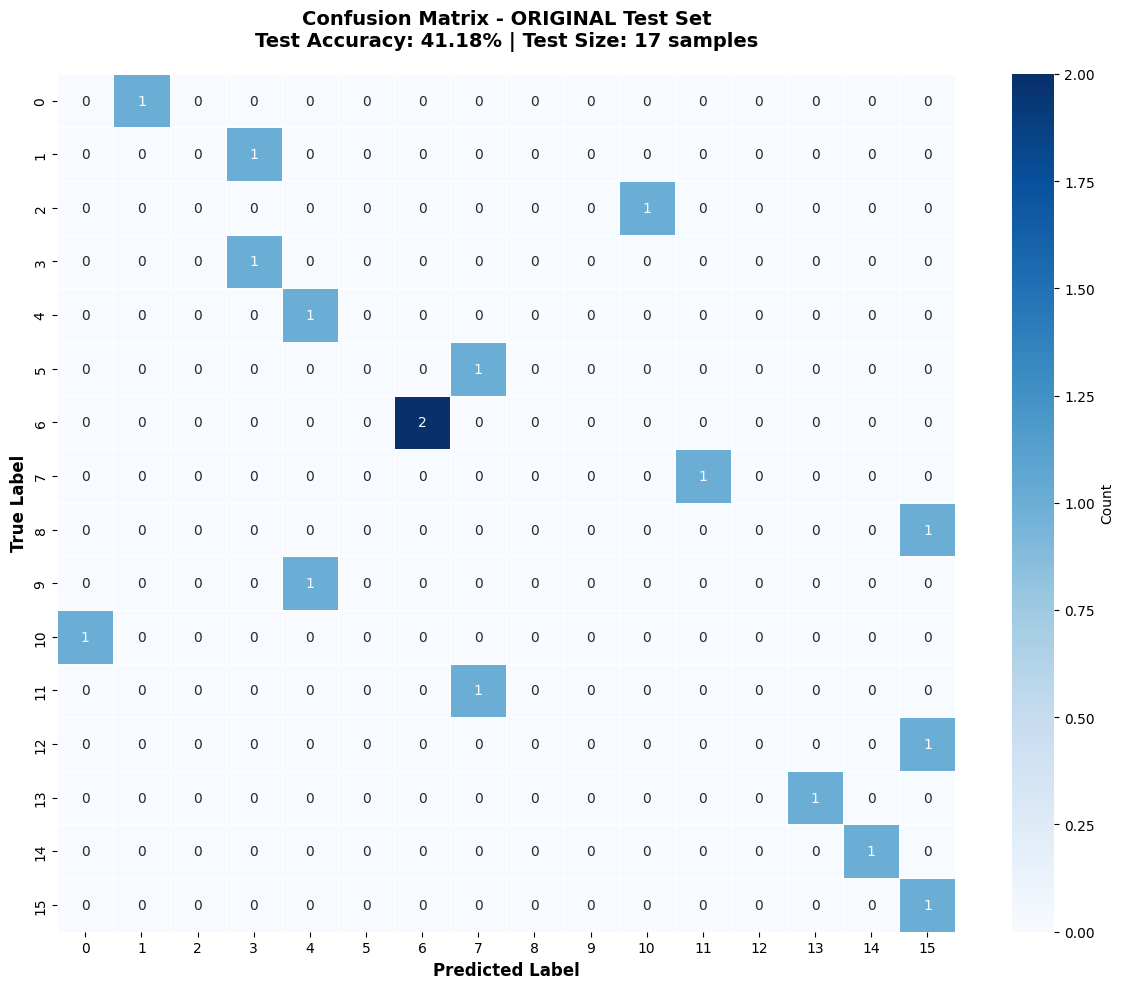

In [84]:
# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=heatmap_labels, yticklabels=heatmap_labels,
            linewidths=0.5, cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title(f'Confusion Matrix - ORIGINAL Test Set\n' + 
          f'Test Accuracy: {test_accuracy:.2%} | Test Size: {len(y_test)} samples',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


NOTES:
- Some classes have 100% correct, some are partially correct and some are 0% correct
- Random guessing baseline: 1/16 => 6.25% accuracy
- This model: 41% accuracy => 7x better than random!
- With only 1 test sample/class, high variance is expected

PROBLEM:
- 48 total samples / 16 classes => 3 samples/class
- After 65/35 split:
- - Training: 2 samples/class =>  Not enough to learn patterns
- - Test: 1 sample/class => Not enough to evaluate reliably

